In [ ]:
!pip install torch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

file_path = '/content/drive/My Drive/snappfood_pre_processed_dataset.csv' # Replace with the copied path
df = pd.read_csv(file_path)
df.head()

,comments,label
0,غذا سرد صورتیکه فاصله,0
1,بهتره بتون ران سینه خودمون انتخاب,1
2,غذا بد حالم بده دل دردو دل پیچه معلوم چی توش ر...,0
3,سلام سابق بسته کیفیت بهتری برخوردار حاضر ایراد...,0
4,سلام منون متشکر,1


In [3]:
df = df.dropna()

In [4]:
from transformers import BertConfig, BertTokenizer, BertForSequenceClassification

model_name = "HooshvareLab/bert-base-parsbert-uncased"

config = BertConfig.from_pretrained(model_name, num_labels=2)
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, config=config)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
comments = df["comments"]
labels = df["label"]

label
1    26004
0    25790
Name: count, dtype: int64


<ipython-input-6-a3e00efbff29>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'label', data = df, palette = 'Set3')


<Axes: xlabel='label', ylabel='count'>

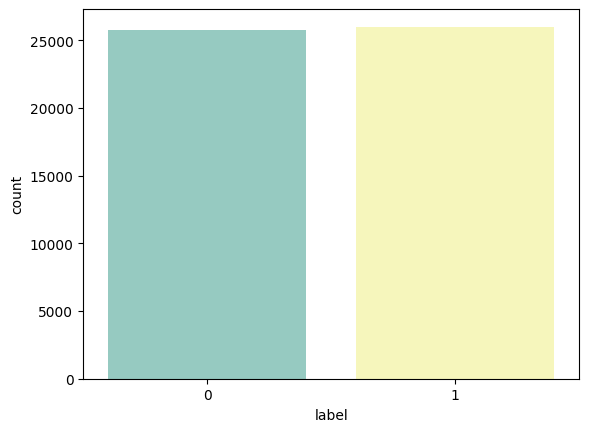

In [6]:
import seaborn as sns

print(df['label'].value_counts())
sns.countplot(x = 'label', data = df, palette = 'Set3')

In [7]:
from sklearn.model_selection import train_test_split

train_comments, temp_comments, train_labels, temp_labels = train_test_split(
    comments, labels, test_size=0.2, stratify=labels, random_state=42
)

val_comments, test_comments, val_labels, test_labels = train_test_split(temp_comments, temp_labels,
                                                                random_state = 2021,
                                                                test_size = 0.5,
                                                                stratify = temp_labels)

In [8]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_len = 128
batch_size = 16
epochs = 5

In [9]:
from torch.utils.data import Dataset

class SnappDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [10]:
from torch.utils.data import DataLoader

train_dataset = SnappDataset(train_comments, train_labels, tokenizer, max_len)
val_dataset = SnappDataset(val_comments, val_labels, tokenizer, max_len)
test_dataset = SnappDataset(test_comments, test_labels, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [11]:
!pip install transformers

In [12]:
from torch.optim import AdamW
from tqdm import tqdm

model = model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch + 1} Loss: {total_loss / len(train_loader):.4f}")


Epoch 1: 100%|██████████| 2590/2590 [16:31<00:00,  2.61it/s, loss=0.196]


Epoch 1 Loss: 0.4170


Epoch 2: 100%|██████████| 2590/2590 [16:31<00:00,  2.61it/s, loss=0.111]


Epoch 2 Loss: 0.3451


Epoch 3: 100%|██████████| 2590/2590 [16:32<00:00,  2.61it/s, loss=0.203]


Epoch 3 Loss: 0.2808


Epoch 4: 100%|██████████| 2590/2590 [16:31<00:00,  2.61it/s, loss=0.186]


Epoch 4 Loss: 0.2093


Epoch 5: 100%|██████████| 2590/2590 [16:30<00:00,  2.62it/s, loss=0.11]

Epoch 5 Loss: 0.1497


In [13]:
from sklearn.metrics import classification_report

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=["happy", "sad"]))


              precision    recall  f1-score   support

       happy       0.82      0.80      0.81      2579
         sad       0.81      0.82      0.81      2601

    accuracy                           0.81      5180
   macro avg       0.81      0.81      0.81      5180
weighted avg       0.81      0.81      0.81      5180



In [ ]:
def predict_sentiment(text):
  inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
  outputs = model(**inputs)
  probs = outputs.logits.softmax(dim=1)
  print(outputs.logits)
  prediction = probs.argmax().item()
  return "+" if prediction == 1 else "-"

print(predict_sentiment("سرد بود وقتی به دست رسید"))
print(predict_sentiment("خوشمزه بود"))
print(predict_sentiment("به موقع ارسال شد"))
print(predict_sentiment("سفارش افتضاح بود!"))

tensor([[ 0.0405, -0.3954]], device='cuda:0', grad_fn=<AddmmBackward0>)
-
tensor([[-1.2599,  1.2828]], device='cuda:0', grad_fn=<AddmmBackward0>)
+
tensor([[-2.1500,  2.6897]], device='cuda:0', grad_fn=<AddmmBackward0>)
+
tensor([[ 1.9359, -2.6361]], device='cuda:0', grad_fn=<AddmmBackward0>)
-
